In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

In [123]:
def plot_data(data):
    x_label = "t"
    y_label = "θr"
    plt.plot(data[x_label], data[y_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [124]:
def get_largo(data):
    data_r = data["r"]
    return data_r.mean(), data_r.std() + 0.1

In [125]:
def format_pd(data):
    data = data.dropna()
    # Arranca en t = 0
    #print(data["t"].iloc[0])
    data["t"] = data["t"] - data["t"].iloc[0]
    # Selecciona la columna de interés
    data = data[data["t"] <=5]
    return data

In [126]:
import math

rm = 1
drm = 0.1

def error_propagation_tita_from_rm_L(L, dL):
    return math.sqrt((L / (drm**2 + L**2))**2 + (rm / (dL**2 + rm**2))**2)

def gen_dθr(L):
    return math.atan(rm/L) + error_propagation_tita_from_rm_L(L, 0.1)

def gen_dicc_with_deltas(dicc, data):
    #data is a pandas dataframe with columns t, x, y, r, tita
    dicc["dx"] = 0.1
    dicc["dy"] = 0.1
    dicc["dr"] = data["r"].std() + 0.1
    dicc["dt"] = 1/30
    L = data["r"].mean()
    dicc["dθr"] = gen_dθr(L)
    dicc["dθ0"] = dicc["dθr"]

def gen_dicc(data):
    dicc = {}
    dicc["drm"] = 0.1
    gen_dicc_with_deltas(dicc, data)
    return dicc

In [127]:
import numpy as np

def get_all_params(data):
    dicc = gen_dicc(data)

    # Incertidumbre en θ y t (suponiendo que los conoces o los calculas)
    sigma_theta = dicc["dθr"]  # Ejemplo de incertidumbre en ángulo
    sigma_t = dicc["dt"]  # Ejemplo de incertidumbre en tiempo

    def get_tita0(data):
        try:
            return data["θr"].iloc[0], sigma_theta  # Incluye la incertidumbre
        except KeyError:
            return data["θ"].iloc[0], sigma_theta

    def get_amplitud(data):
        try:
            theta_max = max(data["θr"])
            theta_min = min(data["θr"])
            amplitud = (theta_max - theta_min) / 2
            # Propagación de incertidumbre en la diferencia
            sigma_amplitud = np.sqrt(2 * sigma_theta**2) / 2  # Incertidumbre en amplitud
            return amplitud, sigma_amplitud
        except KeyError:
            theta_max = max(data["θ"])
            theta_min = min(data["θ"])
            amplitud = (theta_max - theta_min) / 2
            sigma_amplitud = np.sqrt(2 * sigma_theta**2) / 2
            return amplitud, sigma_amplitud

    def get_periodo(data):
        try:
            # Localizo un máximo y un mínimo
            maximo = data["θ"].idxmax()
            minimo = data["θ"].idxmin()
            # Calculo el periodo
            periodo = abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2
            # Propagación de incertidumbre en la resta de tiempos
            sigma_periodo = np.sqrt(2 * sigma_t**2) * 2  # El factor de 2 porque es de pico a pico
            return periodo, sigma_periodo
        except KeyError:
            maximo = data["θr"].idxmax()
            minimo = data["θr"].idxmin()
            periodo = abs((data["t"].iloc[maximo] - data["t"].iloc[minimo])) * 2
            sigma_periodo = np.sqrt(2 * sigma_t**2) * 2
            return periodo, sigma_periodo

    def get_frecuencia(data):
        periodo, sigma_periodo = get_periodo(data)
        frecuencia = 1 / periodo
        # Propagación de incertidumbre en la inversa
        sigma_frecuencia = sigma_periodo / (periodo**2)
        return frecuencia, sigma_frecuencia
    
    tita0, sigma_tita0 = get_tita0(data)
    amplitud, sigma_amplitud = get_amplitud(data)
    periodo, sigma_periodo = get_periodo(data)
    frecuencia, sigma_frecuencia = get_frecuencia(data)
    return tita0, amplitud, periodo, frecuencia, sigma_tita0, sigma_amplitud, sigma_periodo, sigma_frecuencia

In [128]:
def plot_approximation(data, tita0, amplitud, frecuencia, periodo):
    x = data["t"]
    #print(x[0])
    delta = np.arcsin(tita0 / amplitud)
    y = amplitud * np.sin(2 * np.pi * (-frecuencia) * x + delta)
    #print(y[0])
    plt.plot(x, y)

0: plata l3/plata50.csv
(19.538695652173914, 44.29, 46.91, 0.9359999999999999, 1.0683760683760684, 23, 0.2636875246000988, 1.0425608578291583, 0.7372018523706619, 0.09428090415820634, 0.10761480951654424)
1: plata l3/plata45.csv
(19.63130859375, 30.63, 31.125, 0.9359999999999995, 1.068376068376069, 23, 0.18020793966618354, 1.0423371914179433, 0.7370436963345682, 0.09428090415820634, 0.10761480951654434)
2: plata l3/plata40.csv
(19.635245283018868, 23.51, 23.355, 0.9359999999999997, 1.0683760683760688, 23, 0.13011399155103004, 1.0422941736009923, 0.7370132781444902, 0.09428090415820634, 0.1076148095165443)
3: plata l3/plata35.csv
(19.693227848101266, 8.556, 10.2625, 0.8679999999999999, 1.1520737327188941, 23, 0.14104167506517165, 1.0421319979982526, 0.73689860267605, 0.09428090415820634, 0.1251365820019091)
4: oro l1/oro45.csv
(36.93247216035635, 19.09, 20.5, 1.2000000000000002, 0.8333333333333333, 72, 0.15051864714965513, 1.0175415608283513, 0.7195105378008712, 0.09428090415820634, 0.0

/var/folders/d3/lp38b7ms0ynbmnnz4lckj0g80000gn/T/ipykernel_2513/3271748453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["t"] = data["t"] - data["t"].iloc[0]


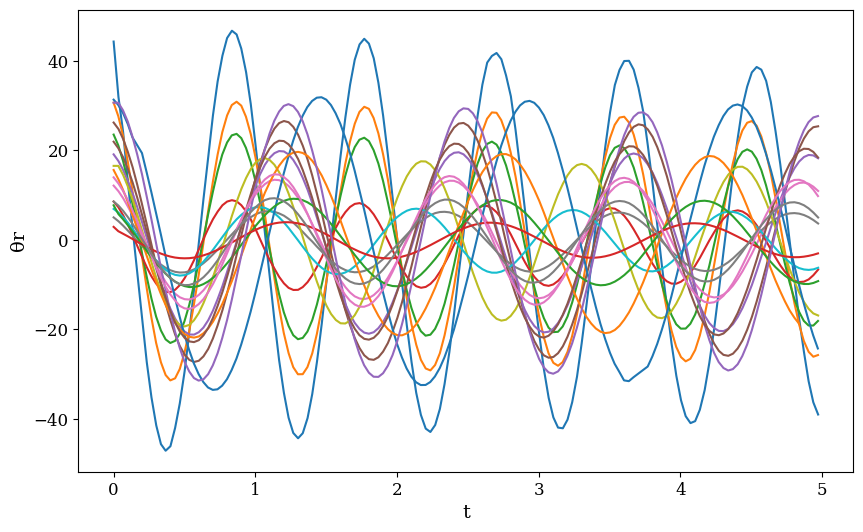

In [129]:
import os
import pandas as pd

# Adjust the input directory path to go up one level from the current directory
input_dir = os.path.join('..', 'datasets')

datasets = []

for folder in os.listdir(input_dir):
    folder_path = os.path.join(input_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith('.csv'):
                # Add dataset to the list with subfolder and folder
                datasets.append(os.path.join(folder, file))

dataset_params = []

for i, dataset in enumerate(datasets):
    print(f"{i}: {dataset}")
    # Load a specific dataset into a DataFrame
    DATASET_CHOSEN = i
    data = pd.read_csv(os.path.join(input_dir, datasets[DATASET_CHOSEN]))
    L, dL = get_largo(data)
    data = format_pd(data)
    plot_data(data)
    #plt.show()
    tita0, amplitud, T, frecuencia, sigma_tita0, sigma_amplitud, sigma_T, sigma_frecuencia = get_all_params(data)
    dicc = gen_dicc(data)
    dataset_params.append((L, tita0, amplitud, T, frecuencia, (23 if dataset.split()[0] == "plata" else 72), dL, sigma_tita0, sigma_amplitud, sigma_T, sigma_frecuencia))
    #print(f"θ0: {tita0}, A: {amplitud}, T: {T}, f: {frecuencia}")
    print(dataset_params[-1])
    #plot_approximation(data, tita0=tita0, amplitud=amplitud, frecuencia=frecuencia, periodo=T)
    #plt.show()


In [130]:
def graph_params(dataset_params):
    # Crear DataFrame con los datos
    df = pd.DataFrame(dataset_params, columns=["L", "tita0", "A", "T", "f", "m", "dL", "sigma_tita0", "sigma_A", "sigma_T", "sigma_f"])

    # Ajuste lineal entre L y T^2 para estimar gravedad
    reg = LinearRegression().fit(df["L"].values.reshape(-1, 1), (df["T"]**2).values.reshape(-1, 1))

    # Parámetros estimados de la gravedad y su incertidumbre
    slope = reg.coef_[0][0]
    intercept = reg.intercept_[0]
    g_estimated = (4 * np.pi**2 / slope) / 100  # de cm a m
    residuals = (df["T"]**2) - (slope * df["L"] + intercept)
    residual_sum_of_squares = np.sum(residuals**2)
    degrees_of_freedom = len(df["L"]) - 2
    standard_error = np.sqrt(residual_sum_of_squares / degrees_of_freedom)
    slope_uncertainty = standard_error / np.sqrt(np.sum((df["L"] - df["L"].mean())**2))
    g_uncertainty = g_estimated * (slope_uncertainty / slope)

    print(f"Estimated gravity (g): {g_estimated} ± {g_uncertainty} m/s^2")

    # Gráfico T^2 vs L con ajuste lineal y área de incertidumbre
    plt.figure(figsize=(10, 6))
    plt.errorbar(df["L"], df["T"]**2, label='Datos experimentales', xerr=df["dL"], yerr=df["sigma_T"] * 2 * df["T"], fmt='o')
    
    x = np.linspace(df["L"].min(), df["L"].max(), 100)
    plt.plot(x, reg.predict(x.reshape(-1, 1)), color="red", label='Ajuste lineal')
    delta = 2 * df["sigma_T"].mean() * df["T"].mean()
    plt.fill_between(x,
                     reg.predict(x.reshape(-1, 1)).reshape(-1) - delta,
                     reg.predict(x.reshape(-1, 1)).reshape(-1) + delta,
                     color='red', alpha=0.2, label="Intervalo de incertidumbre")
    g_theoretical = 9.80665 * 100
    plt.plot(x, (4 * np.pi**2 / g_theoretical) * x, color="green", label='Recta teórica')
    
    plt.xlabel(r'$Largo\ [cm]$', fontsize=16)
    plt.ylabel(r'$T^2\ [s^2]$', fontsize=16)

    plt.legend(fontsize=12)
    plt.show()

    # Gráfico T vs m con gradiente de color basado en L
    df["L"] = df["L"].round(1)
    unique_lengths = np.sort(df["L"].unique())
    norm = plt.Normalize(df["L"].min(), df["L"].max())
    colors = plt.cm.viridis(norm(unique_lengths))

    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    for length, color in zip(unique_lengths, colors):
        subset = df[df["L"] == length]
        ax.errorbar(subset["m"], subset["T"], yerr=subset["sigma_T"], fmt='o', color=color, xerr=1)

    plt.xlabel(r'$Masa\ [g]$', fontsize=16)
    plt.ylabel(r'$T\ [s]$', fontsize=16)

    
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=r'$Largo\ [cm]$')
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    # Gráfico T vs tita0 con gradiente de color basado en L
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    for length, color in zip(unique_lengths, colors):
        subset = df[df["L"] == length]
        ax.errorbar(subset["tita0"], subset["T"], yerr=subset["sigma_T"], fmt='o', color=color, xerr=0.2)

    plt.xlabel(r'$\theta_0\ [deg]$', fontsize=16)
    plt.ylabel(r'$T\ [s]$', fontsize=16)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label=r'$Largo\ [cm]$')
    plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

Estimated gravity (g): 9.321777711572654 ± 0.519416981690778 m/s^2


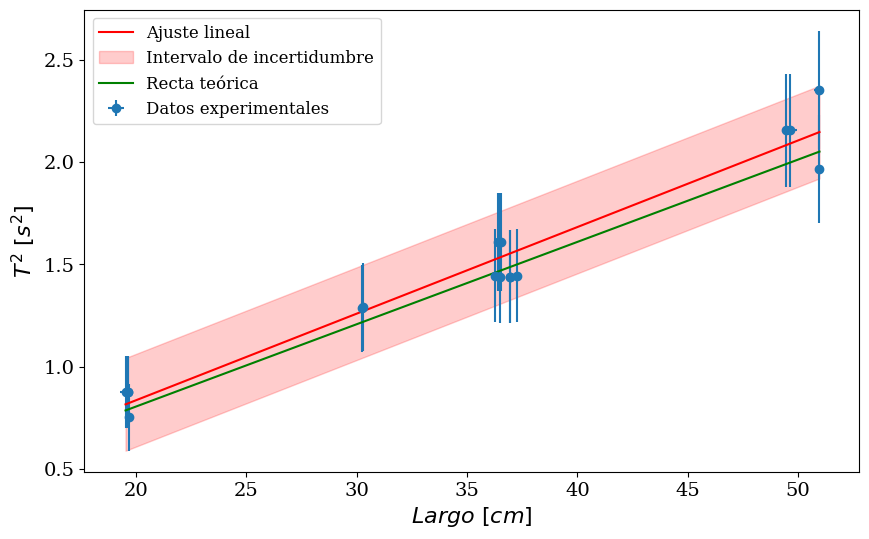

/var/folders/d3/lp38b7ms0ynbmnnz4lckj0g80000gn/T/ipykernel_2513/566228498.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))


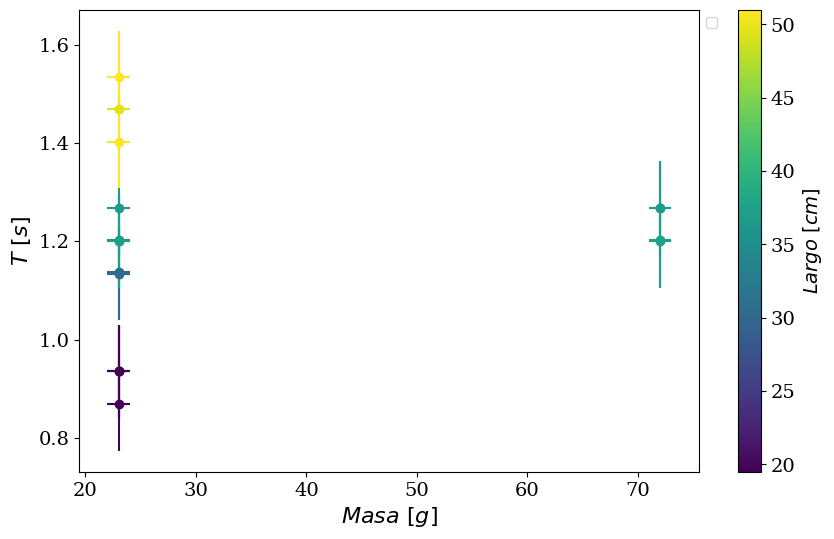

/var/folders/d3/lp38b7ms0ynbmnnz4lckj0g80000gn/T/ipykernel_2513/566228498.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))


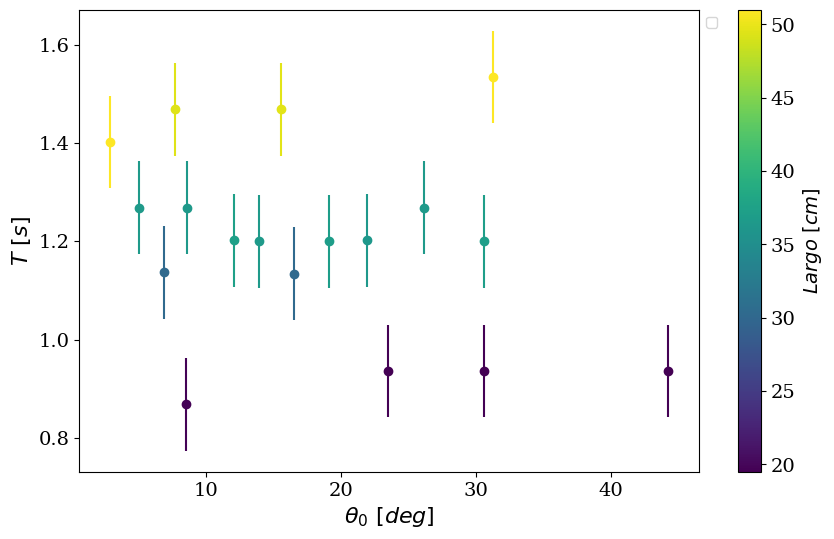

In [131]:
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    
    "legend.fontsize": 12})



graph_params(dataset_params)